# LMU Code Coffee: [JAX](https://github.com/google/jax)
Brett Morris

### Install

Installation of jax is sometimes [nontrivial](https://github.com/google/jax#installation), but if you're feeling lucky, you can try the following on your laptop (CPU): 
```bash
pip install --upgrade "jax[cpu]"
```
jax can run on GPUs and TPUs but requires specific builds for each system. See the link above for details.

### Why jax?

It exploits [_autodiff_](https://github.com/hips/autograd) with [_accelerated linear algebra_](https://www.tensorflow.org/xla) with a _numpy-like API_ but a [_just-in-time compiled backend_](https://github.com/google/jax#compilation-with-jit) to calculate blazing fast, differentiable models. Let's break that down: 

* The automatic differentiation allows you to compute gradients of your mathematical models without explicitly deriving gradients for each function. These gradients can be used for gradient-based inference techniques like Hamiltonian Monte Carlo.
* The accelerated linear algebra (XLA) package is an optimizing compiler designed for machine learning. You write Python code and it gets just-in-time compiled before you execute it.


### What does jax code look like? 

It looks like ordinary Python code, but you generally use jax's numpy API rather than ordinary numpy to handle array calculations.  

For example, here's how we can create an array of linearly spaced values:

In [107]:
from jax import numpy as jnp

dev_arr = jnp.linspace(0, 1, 10_000_000)

dev_arr[:10]

DeviceArray([0.0000000e+00, 1.0000001e-07, 2.0000002e-07, 3.0000001e-07,
             4.0000003e-07, 5.0000006e-07, 6.0000002e-07, 7.0000004e-07,
             8.0000007e-07, 9.0000009e-07], dtype=float32)

Note that the above code created a `DeviceArray` object, which is not an ordinary numpy array. This is limited to data type `float32` by default. `DeviceArray` objects have the usual built-in methods: 

In [108]:
dev_arr.mean(), dev_arr.std()

(DeviceArray(0.5, dtype=float32), DeviceArray(0.28867516, dtype=float32))

Now let's create some synthetic data which we'll fit using jax: 

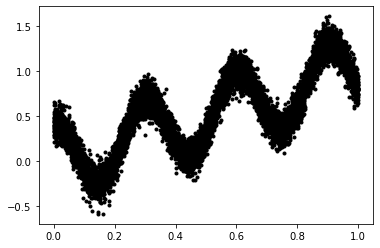

In [186]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

x = dev_arr.copy()
true_period = 0.3
true_amp = 0.4
true_slope = 1
yerr = 0.1


y = np.asarray(
    yerr * np.random.normal(size=len(x)) + true_amp * np.cos(2 * np.pi * x / true_period) + true_slope * x, 
    dtype='float32'
)

plt.plot(x[::1000], y[::1000], 'k.')

We could fit the observations $(x, y)$ with numpy and scipy like this: 

In [208]:
from scipy.optimize import fmin_powell, fmin_l_bfgs_b

def model_numpy(p):
    period, amp, slope, phi = p
    
    return amp * np.cos(2 * np.pi * np.asarray(x, dtype='float32') / period - phi) + slope * np.asarray(x, dtype='float32')

def chi2_numpy(p):
    return np.sum((model_numpy(p) - np.asarray(y, dtype='float32'))**2 / yerr**2)

init_guess = [0.35, 0.4, 1.1, 0]
bounds = [[0.2, 0.6], [0.01, 1], [0.5, 1.5], [-np.pi, np.pi]]

bestp_numpy = fmin_l_bfgs_b(chi2_numpy, init_guess, approx_grad=True, bounds=bounds, factr=10)

The `fmin_powell` function does optimization _without_ computing gradients. The best fit solutions are: 

In [209]:
bestp_numpy

(array([0.30180746, 0.4       , 1.1       , 0.        ]),
 140278.34,
 {'grad': array([0., 0., 0., 0.]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 15,
  'nit': 1,
  'warnflag': 0})

Which look like this: 

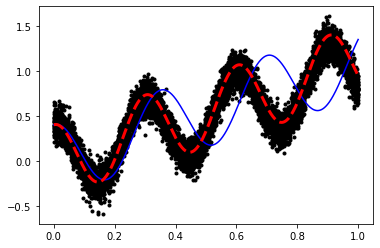

In [210]:
plt.plot(x[::1000], y[::1000], 'k.')
plt.plot(x[::1000], model_numpy(init_guess)[::1000], 'b')
plt.plot(x[::1000], model_numpy(bestp_numpy[0])[::1000], 'r', ls='--', lw=3)

Which are all close to their true values. Good job numpy/scipy! Now let's implement the same thing in jax. 

Let's specify the model that we will fit to the data using the numpy module within jax. We'll also "decorate" it with the `jit` decorator, which will compile the function for us. 

In [118]:
from jax import jit

@jit
def model_jax(p): 
    period, amp, slope = p
    
    # the use of `jnp` is the only difference from the numpy version:
    return amp * jnp.cos(2 * np.pi * x / period) + slope * x

@jit
def chi2_jax(p):
    return jnp.sum((model_jax(p) - y)**2)

Now we import the minimize module from the `scipy.optimize` API within jax: 

In [119]:
from jax.scipy.optimize import minimize

bestp_jax = minimize(chi2_jax, jnp.array(init_guess), method='bfgs')

bestp_jax

OptimizeResults(x=DeviceArray([-1.0875516 ,  0.04143282,  1.0564185 ], dtype=float32), success=DeviceArray(False, dtype=bool), status=DeviceArray(3, dtype=int32, weak_type=True), fun=DeviceArray(868919.4, dtype=float32), jac=DeviceArray([ 7.8125000e-03, -5.1500000e+01,  9.2421875e+01], dtype=float32), hess_inv=DeviceArray([[ 4.0762707e-06, -1.4142411e-07, -5.1208372e-07],
             [-1.4142574e-07,  1.1900859e-07,  4.7038686e-08],
             [-5.1208451e-07,  4.7038359e-08,  2.2042782e-07]],            dtype=float32), nfev=DeviceArray(63, dtype=int32, weak_type=True), njev=DeviceArray(63, dtype=int32, weak_type=True), nit=DeviceArray(28, dtype=int32, weak_type=True))

In the above cell, we have used _gradient-based_ optimization with the [BFGS method](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Note that we didn't have to specify the gradient of our model with respect to each free parameter, that was done for us!

Now let's check if there's any speed difference between the two implementations:

In [120]:
print('Numpy only:')
time_numpy = %timeit -o model_numpy(init_guess)
print('jax:')
time_jax = %timeit -o model_jax(init_guess)

Numpy only:
31.8 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
jax:
15.8 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like the two models have similar in speeds, but the optimization is significantly different:

In [121]:
print('Numpy only:')
time_numpy_opt = %timeit -o fmin_l_bfgs_b(chi2_numpy, init_guess, disp=0, approx_grad=True)
print('jax:')
time_jax_opt = %timeit -o minimize(chi2_jax, jnp.array(init_guess), method='bfgs')

Numpy only:
165 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
jax:
4.46 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The optimization is much slower!